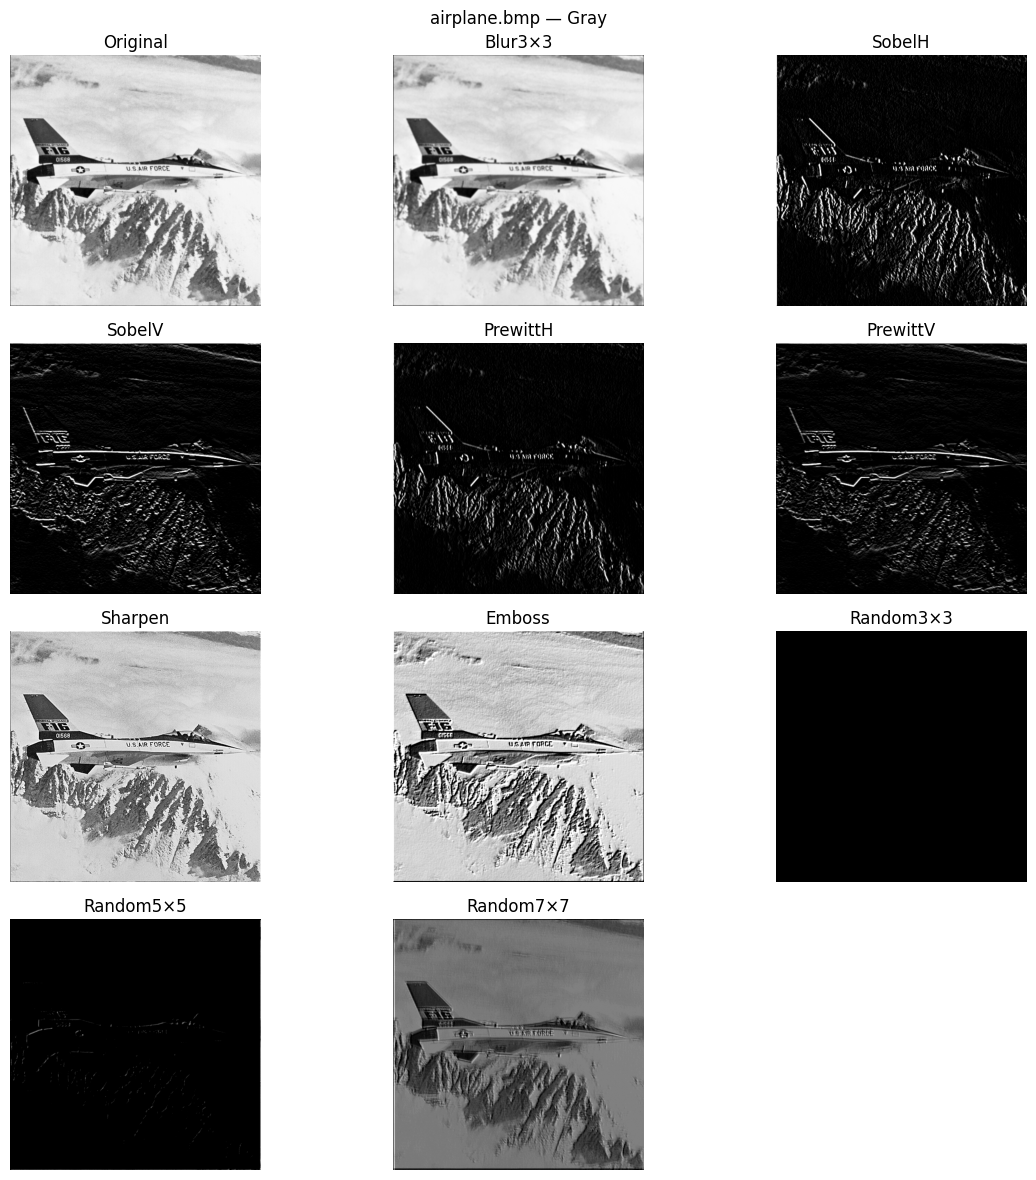

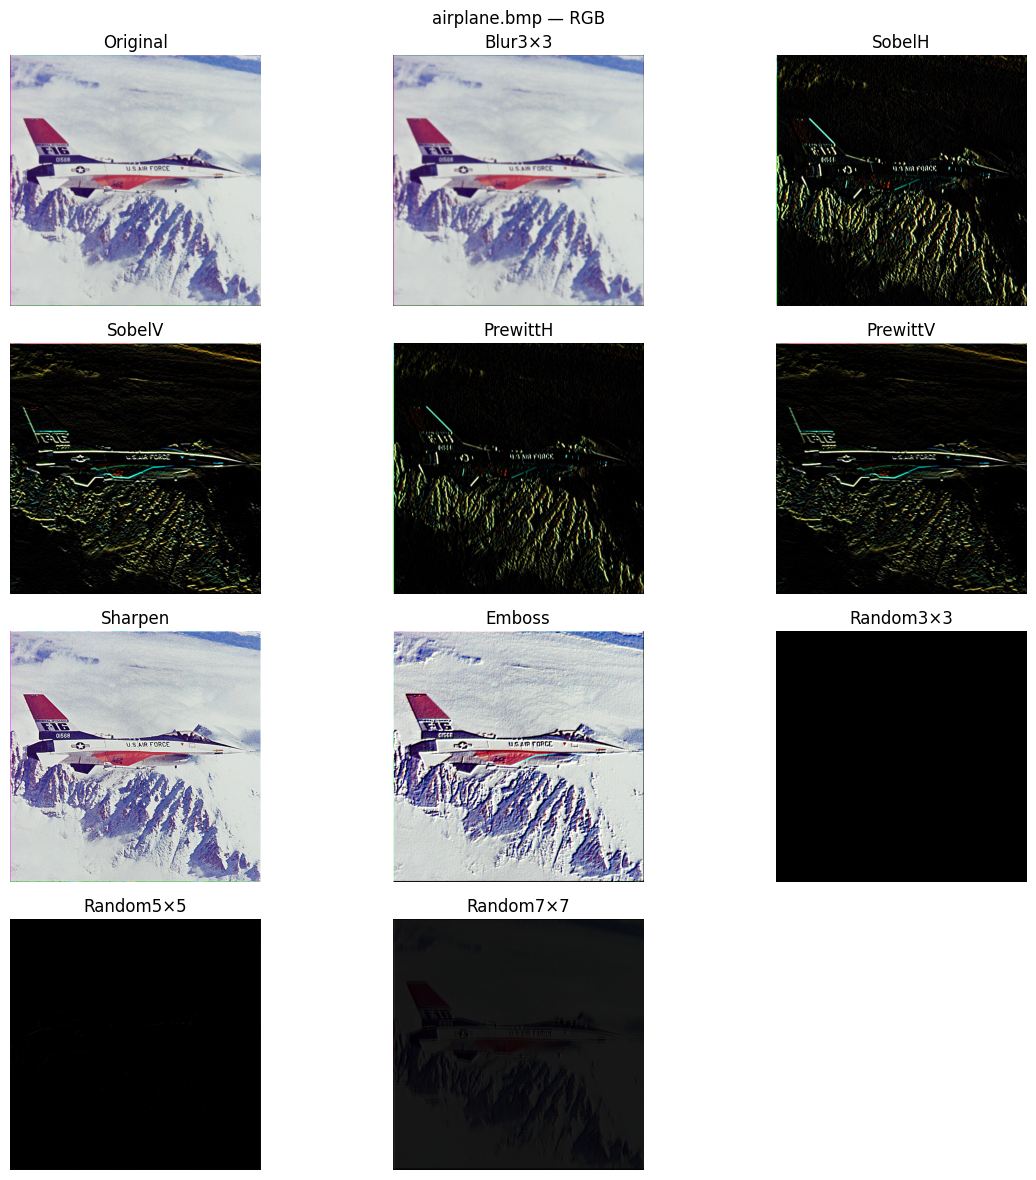

In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# 1) Chargement avec assertions
def image_load(path, channel=None):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    assert img is not None, f"Erreur : impossible de charger {path}"
    # Détection automatique du channel si non précisé
    if channel is None:
        channel = 1 if img.ndim == 2 else 3
    # Conversion
    if channel == 1:
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# 2) Convolution sur un seul canal avec assertions de taille
def convolve_channel(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    assert h >= kh and w >= kw, "Image trop petite pour ce noyau"
    pad_h, pad_w = kh//2, kw//2
    padded = np.pad(image, ((pad_h,pad_h),(pad_w,pad_w)), mode='constant')
    out = np.zeros_like(image, dtype=np.float32)
    for i in range(h):
        for j in range(w):
            out[i,j] = np.sum(padded[i:i+kh, j:j+kw] * kernel)
    assert out.shape == image.shape, f"sortie {out.shape} vs entrée {image.shape}"
    return out

# 3) Application multi-canal avec assertions de sortie
def apply_convolution(image, kernel):
    assert isinstance(image, np.ndarray) and isinstance(kernel, np.ndarray)
    assert kernel.ndim == 2 and kernel.shape[0] == kernel.shape[1] and kernel.shape[0] % 2 == 1
    assert image.ndim in (2,3)
    if image.ndim == 3:
        assert image.shape[2] == 3, "Image RGB doit avoir 3 canaux"
        out = np.zeros_like(image, dtype=np.float32)
        for c in range(3):
            out[:,:,c] = convolve_channel(image[:,:,c], kernel)
    else:
        out = convolve_channel(image, kernel)
    out = np.clip(out, 0, 255).astype(np.uint8)
    assert out.shape == image.shape, f"sortie {out.shape} vs entrée {image.shape}"
    return out

# 4) Affichage groupé
def display_all_filters(original, filtered_dict, title=""):
    n = len(filtered_dict) + 1
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    plt.suptitle(title)
    # Original
    plt.subplot(rows, cols, 1)
    plt.title("Original"); plt.axis('off')
    plt.imshow(original, cmap='gray' if original.ndim==2 else None)
    # Filtres
    idx = 2
    for name, img in filtered_dict.items():
        plt.subplot(rows, cols, idx)
        plt.title(name); plt.axis('off')
        plt.imshow(img, cmap='gray' if img.ndim==2 else None)
        idx += 1
    plt.tight_layout()
    plt.show()

# 5) Définitions de TOUS les noyaux
kernels = {
    "Blur3×3":    np.ones((3,3))/9,
    "SobelH":     np.array([[-1,0,1],[-2,0,2],[-1,0,1]]),
    "SobelV":     np.array([[-1,-2,-1],[0,0,0],[1,2,1]]),
    "PrewittH":   np.array([[-1,0,1],[-1,0,1],[-1,0,1]]),
    "PrewittV":   np.array([[-1,-1,-1],[0,0,0],[1,1,1]]),
    "Sharpen":    np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]),
    "Emboss":     np.array([[-2,-1,0],[-1,1,1],[0,1,2]]),
}
for size in (3,5,7):
    np.random.seed(42 + size)
    R = np.random.randn(size,size)
    kernels[f"Random{size}×{size}"] = R / np.sum(np.abs(R))

# 6) Traitement de toutes les images du dossier
src_folder, out_folder = "testimages", "out"
os.makedirs(out_folder, exist_ok=True)

for fname in sorted(os.listdir(src_folder)):
    if not fname.lower().endswith((".png",".jpg",".jpeg",".bmp")):
        continue
    path = os.path.join(src_folder, fname)
    gray = image_load(path, channel=1)
    rgb  = image_load(path, channel=3)

    # Appliquer chaque filtre
    res_gray = {n: apply_convolution(gray, k) for n,k in kernels.items()}
    res_rgb  = {n: apply_convolution(rgb,  k) for n,k in kernels.items()}

    # Affichage
    display_all_filters(gray, res_gray, f"{fname} — Gray")
    display_all_filters(rgb,  res_rgb,  f"{fname} — RGB")

    # Sauvegarde
    base = os.path.splitext(fname)[0]
    for n, img in res_gray.items():
        cv2.imwrite(f"{out_folder}/{base}_{n}_gray.png", img)
    for n, img in res_rgb.items():
        cv2.imwrite(f"{out_folder}/{base}_{n}_rgb.png",
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
